In [133]:
'''
This notebook categorizes the splicing status of each intron in long read data and calculates CoSE values.
Figures 2 and S3
'''

'\nThis notebook categorizes the splicing status of each intron in long read data and calculates CoSE values.\nFigures 2 and S3\n'

In [271]:
import os

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import mygene
import itertools
import scipy
import pysam
import pybedtools
from pybedtools import BedTool

from plotnine import *
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # export pdfs with editable font types in Illustrator
import uuid # for generating unqiue random IDs

In [231]:
# read in from annotation files...
# Read in files with total RNAseq read counts at introns and flanking exons
rnaseq_cts_all = pd.read_csv('../annotation_files/200916_Untreated_10readcutoff_RNAseq_Intronic_vs_Flanking_Exon_Signal.txt', sep = '\t')
rnaseq_cts = rnaseq_cts_all[['Gene.ID', 'Intron_Div_Flanking_Exons']] # trim this dataframe down to just get intron name and intron/exon read counts (normalized by length for each)

### Part 1: Create intron and 3'SS annotation files
This cell only needs to be run once to generate all the annotation files needed

In [137]:
# Set links to intron annotation file in BED format and list of active TSSs (defined from PROseq data)
all_introns = pd.read_csv('../annotation_files/mm10_VM20_introns.bed.gz', delimiter = '\t', names =  ['chr', 'start', 'end', 'name', 'score', 'strand'], compression = 'gzip') # annotation of all mm10 introns in BED6 format, downloaded from USCS table browser
active_TSS = pd.read_csv('../annotation_files/active_TSS_PROseq_150_counts_mm10_VM20.txt', delimiter = '\t', header = 0)

# Set parameters for 3SS window cutoff value
window = 35 # distance upstream of 3SS to consider in splicing status classification

####################################################################################################################

active_genes = active_TSS.groupby(['geneid'])
print('Number of actively transcribed genes in MEL = ' + str(len(active_genes)))

# add a column for txid
all_introns['txid'] = all_introns.name.str.split('_').str[0]

# Define a function to filter out introns that are not used in MEL cells according to PROseq data, i.e. introns that are upstream of active TSSs for each transcript ID
def remove_unused_introns(TSS_file, intron_file):
    
    # First get the transcript with the outermost TSS for each gene ID
    active_TSS_plus = TSS_file[TSS_file['strand'] == '+']
    active_TSS_minus = TSS_file[TSS_file['strand'] == '-']
    plus_outer = active_TSS_plus.loc[active_TSS_plus.groupby('geneid')['start'].idxmin()]
    minus_outer = active_TSS_minus.loc[active_TSS_minus.groupby('geneid')['start'].idxmax()]

    # Get transcript ID from intron ID and split introns by strand
#     intron_file['txid'] = intron_file.name.str.split('_').str[0]
    introns_plus = intron_file[intron_file['strand'] == '+']
    introns_minus = intron_file[intron_file['strand'] == '-']
    
    # Join TSS dfs and intron dfs by transcript ID
    joined_plus = pd.merge(introns_plus, plus_outer, left_on = 'txid', right_on = 'txname', how = 'left')
    joined_minus = pd.merge(introns_minus, minus_outer, left_on = 'txid', right_on = 'txname', how = 'left')

    # For each intron, check whether start is at or downstream of most active TSS
    keep_plus = joined_plus[joined_plus['start_x'] >= joined_plus['start_y']]
    keep_minus = joined_minus[joined_minus['start_x'] <= joined_minus['start_y']]
    
    joined = pd.concat([joined_plus, joined_minus])
    keep = pd.concat([keep_plus, keep_minus])
    return keep

active_introns = remove_unused_introns(active_TSS, all_introns)
active_introns = active_introns[['chr_x', 'start_x', 'end_x', 'name', 'score_x', 'strand_x']]
active_introns.columns = ['chr', 'start', 'end', 'name', 'score', 'strand']

# create a file of unique introns for later use
all_introns['start'] = all_introns['start'].astype(str)
all_introns['end'] = all_introns['end'].astype(str)

# create a unique ID string for each intron coordinate (this makes dropping duplicates easier)
all_introns['ID'] = all_introns.chr.str.cat(all_introns.start,sep="_")
all_introns['ID'] = all_introns.ID.str.cat(all_introns.end,sep="_")
all_introns['ID'] = all_introns.ID.str.cat(all_introns.strand,sep="_")
all_introns['ID'] = all_introns['ID'].str.strip()

# drop duplicate intron coordinates
all_introns_unique = all_introns.drop_duplicates(subset = 'ID', keep = 'first')

print('Total number of introns is: ' + str(len(all_introns.index)))
print('Number of unique introns is: ' + str(len(all_introns_unique.index)))

# save unique introns with correct coordinates for downstream use
all_introns_unique.to_csv('../annotation_files/mm10_VM20_introns_unique.bed', 
               sep = '\t', 
               index = False,
               columns = ['chr', 'start', 'end', 'name', 'score', 'strand'], 
               header = False)

# create a unique ID string for each intron coordinate
active_introns['start'] = active_introns['start'].astype(str)
active_introns['end'] = active_introns['end'].astype(str)

active_introns['ID'] = active_introns.chr.str.cat(active_introns.start,sep="_")
active_introns['ID'] = active_introns.ID.str.cat(active_introns.end,sep="_")
active_introns['ID'] = active_introns.ID.str.cat(active_introns.strand,sep="_")
active_introns['ID'] = active_introns['ID'].str.strip()

# drop duplicate intron coordinates
active_introns_unique = active_introns.drop_duplicates(subset = 'ID', keep = 'first')

###############
# # drop duplicate intron coordinates, and keep the intron closer to the TSS
# # first separate by strand, and make sure df is sorted by chr, start, end
# active_introns_plus = active_introns.loc[active_introns['strand'] == '+']
# active_introns_minus = active_introns.loc[active_introns['strand'] == '-']
# active_introns_plus = active_introns_plus.sort_values(by = ['chr', 'start', 'end'], ascending = False)
# active_introns_minus = active_introns_minus.sort_values(by = ['chr', 'start', 'end'], ascending = False)
# # for plus strand introns, keep first, for minus strand intron, keep last
# active_introns_plus_unique = active_introns_plus.drop_duplicates(subset = 'ID', keep = 'first')
# active_introns_minus_unique = active_introns_minus.drop_duplicates(subset = 'ID', keep = 'last')

# active_introns_unique = pd.concat([active_introns_plus_unique, active_introns_minus_unique]) # concat plus and minus strand introns back together
###############

print('Total number of introns from active transcripts is: ' + str(len(active_introns.index)))
print('Number of unique introns from active transcripts is: ' + str(len(active_introns_unique.index)))

# save unique introns with correct coordinates for downstream use
active_introns_unique.to_csv('../annotation_files/mm10_VM20_active_introns_unique_real_coordinates.bed', 
               sep = '\t', 
               index = False,
               columns = ['chr', 'start', 'end', 'name', 'score', 'strand'], 
               header = False)

# add 1 nucleotide to the start and end of each intron coordinate
active_introns_unique['windowStart'] = (active_introns_unique['start'].astype('int')) - 1
active_introns_unique['windowEnd'] = (active_introns_unique['end'].astype('int')) + 1

# Save unique introns to file for bedtool intersect
active_unique_introns_filename = "mm10_VM20_introns_unique.bed"
active_introns_unique.to_csv(active_unique_introns_filename, 
               sep = '\t', 
               index = False, 
               columns = ['chr', 'windowStart', 'windowEnd', 'name', 'score', 'strand'], 
               header = False)


introns_3ss = active_introns.drop(columns = ['ID'])
introns_3ss.reset_index(inplace = True)

# generate a table with windows of 3SS coordinates using window distance
# first assign 3SS and 5SS based on strand
introns_3ss.loc[introns_3ss['strand'] == '+', 'threeSS'] = introns_3ss['end']
introns_3ss.loc[introns_3ss['strand'] == '-', 'threeSS'] = introns_3ss['start']
introns_3ss.loc[introns_3ss['strand'] == '+', 'fiveSS'] = introns_3ss['start']
introns_3ss.loc[introns_3ss['strand'] == '-', 'fiveSS'] = introns_3ss['end']

# convert coordinates back to integer values
introns_3ss['threeSS'] = introns_3ss['threeSS'].astype(np.int64)
introns_3ss['fiveSS'] = introns_3ss['fiveSS'].astype(np.int64)
introns_3ss['start'] = introns_3ss['start'].astype(np.int64)

# make a window around 3SS using defined window length
introns_3ss.loc[introns_3ss['strand'] == '+', 'windowStart'] = (introns_3ss['threeSS'] - window)
introns_3ss.loc[introns_3ss['strand'] == '-', 'windowStart'] = (introns_3ss['threeSS'] - 1)
introns_3ss.loc[introns_3ss['strand'] == '+', 'windowEnd'] = (introns_3ss['threeSS'] + 1)
introns_3ss.loc[introns_3ss['strand'] == '-', 'windowEnd'] = (introns_3ss['start'] + window)

# return window start and end coordinates to intergers rather than floats
introns_3ss['windowStart'] = introns_3ss['windowStart'].astype(np.int64)
introns_3ss['windowEnd'] = introns_3ss['windowEnd'].astype(np.int64)

# create a unique ID string for each 3'SS genomic coordinate
introns_3ss['threeSS'] = introns_3ss['threeSS'].astype('str')

introns_3ss['ID'] = introns_3ss.chr.str.cat(introns_3ss.threeSS,sep="_")
introns_3ss['ID'] = introns_3ss.ID.str.cat(introns_3ss.strand,sep="_")
introns_3ss['ID'] = introns_3ss['ID'].str.strip()

# collapse to keep only one intron per unique 3SS - the first intron ID will be kept, not necessarily the correct intron, but will be used for counting purposes
introns_unique_3SS = introns_3ss.drop_duplicates(subset = 'ID', keep = 'first')

print('Total number of active introns is: ' + str(len(introns_3ss.index)))
print('Number of active unique 3SS is: ' + str(len(introns_unique_3SS.index)))

# save 3SS file in BED6 format
intron_window_filename = "mm10_introns_{window}_bp_window.bed".format(**locals()) # save filename with window as specified above
# introns_unique['windowStart'] = introns_unique['windowStart'].astype(int)
# introns_unique['windowEnd'] = introns_unique['windowEnd'].astype(int)
introns_unique_3SS.to_csv(intron_window_filename, 
               sep = '\t', 
               index = False, 
               columns = ['chr', 'windowStart', 'windowEnd', 'name', 'score', 'strand'], 
               header = False)

Number of actively transcribed genes in MEL = 13406
Total number of introns is: 679793
Number of unique introns is: 281785
Total number of introns from active transcripts is: 91582
Number of unique introns from active transcripts is: 91339
Total number of active introns is: 91582
Number of active unique 3SS is: 91294


### Part 2: Bedtools intersect to get reads overlapping introns and 3'SS

In [240]:
# Bedtools intersect to get information about which intron windows each read intersects
### THIS IS NOT WORKING WITH PYBEDTOOLS IN THE JUPYTER NOTEBOOK FOR SOME REASON, RUN THESE COMMANDS IN TERMINAL ###

##########################################################################################################################################################################################  
# bedtools intersect -a ../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 1_untreated_RSII_intersect.bed
# bedtools intersect -a ../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 1_untreated_SQ_intersect.bed
# bedtools intersect -a ../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 2_untreated_RSII_intersect.bed
# bedtools intersect -a ../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 2_untreated_SQ_intersect.bed
# bedtools intersect -a ../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 3_DMSO_RSII_intersect.bed
# bedtools intersect -a ../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 3_DMSO_SQ_intersect.bed
# bedtools intersect -a ../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 4_DMSO_RSII_intersect.bed
# bedtools intersect -a ../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 4_DMSO_SQ_intersect.bed
##########################################################################################################################################################################################  

In [151]:
# Bedtools intersect to get information about which 3'SS windows each read intersects
### THIS IS NOT WORKING WITH PYBEDTOOLS IN THE JUPYTER NOTEBOOK FOR SOME REASON, RUN THESE COMMANDS IN TERMINAL ###

########################################################################################################################################################################################## 
# bedtools intersect -a ../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 1_untreated_RSII_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 1_untreated_SQ_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 2_untreated_RSII_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 2_untreated_SQ_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 3_DMSO_RSII_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 3_DMSO_SQ_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 4_DMSO_RSII_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 4_DMSO_SQ_3SS_intersect.bed
# ########################################################################################################################################################################################## 

In [152]:
# Enter list of intersect files that were created using entire introns and 3'SS windows (from terminal bedtools command)
# NOTE: it is important that corresponding files are entered in the same order for intron and 3SS intersect files

intersectFiles = [
                  '1_untreated_RSII_intersect.bed',
                  '1_untreated_SQ_intersect.bed',
                  '2_untreated_RSII_intersect.bed',
                  '2_untreated_SQ_intersect.bed',
                  '3_DMSO_RSII_intersect.bed',
                  '3_DMSO_SQ_intersect.bed',
                  '4_DMSO_RSII_intersect.bed',
                  '4_DMSO_SQ_intersect.bed',
                  ]

intersect3SSFiles = [
                    '1_untreated_RSII_3SS_intersect.bed',
                    '1_untreated_SQ_3SS_intersect.bed',
                    '2_untreated_RSII_3SS_intersect.bed',
                    '2_untreated_SQ_3SS_intersect.bed',
                    '3_DMSO_RSII_3SS_intersect.bed',
                    '3_DMSO_SQ_3SS_intersect.bed',
                    '4_DMSO_RSII_3SS_intersect.bed',
                    '4_DMSO_SQ_3SS_intersect.bed',                   
                     ]

### Part 3: Define Splicing Status for Each Intron

In [153]:
# Define a function that classifies each intron-overlapping region of a read as spliced or unspliced using WHOLE INTRON INTERSECT
def get_splicing_status_full_intron(intersect_bedfile):
    
    filestring = intersect_bedfile.split('/')[-1].split('_')[0:3] # get sample ID from file name
    sample = '_'.join(filestring) 
    
    f = open(intersect_bedfile)
    
    result = [] # generate empty list for each row to be written to
    cols = ['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'readStart', 'readEnd', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'i_chr', 'i_start', 'i_end', 'i_name', 'i_score', 'i_strand', 'overlaps', 'sample', 'spliced_exact', 'unspliced', 'spliced_half', 'false_count'] # output column names
    
    for line in f:
        col = line.rstrip().split("\t")
        int_coord1 = col[13] 
        int_coord2 = col[14]
        intron = ((int(int_coord1)+1), (int(int_coord2)-1)) # create a pair of the intron coordinates

        readStart = col[1]
        readEnd = col[2]
        blockStarts = col[11].split(",")
        blockSizes = col[10].split(",")

        n = int(col[9]) # get number of blocks to use as counter
        junclist = [] # create an empty list for coordinates of junctions in each read

        # to make a search window around the intron annotation to check if a ready is really unspliced or spliced to a neighboring intron 
        false_count = 0 #false_count to be used for if statments below 
        intron_range0A = range(intron[0]-10,intron[0])
        intron_range0B = range(intron[0],intron[0]+10)
        intron_range1A = range(intron[1]-10,intron[1])
        intron_range1B = range(intron[1],intron[1]+10) 

        for i in range(1,n):
            juncStart = int(readStart) + int(blockSizes[i-1]) + int(blockStarts[i-1])
            juncEnd = int(readStart) + int(blockStarts[i])
            junc = (juncStart,juncEnd)
            junclist.append(junc) # add each junction to a list of junctions in the read 

            # if the junction annotation is within a window of the search window, false_count = 1. The long-read will not be counted as unspliced
            if junc[0] in intron_range0A:
                false_count = 1 
            elif junc[0] in intron_range0B: 
                false_count = 1
            elif junc[0] in intron_range1A: 
                false_count = 1
            elif junc[0] in intron_range1B: 
                false_count = 1
            elif junc[1] in intron_range0A:
                false_count = 1 
            elif junc[1] in intron_range0B: 
                false_count = 1
            elif junc[1] in intron_range1A: 
                false_count = 1
            elif junc[1] in intron_range1B: 
                false_count = 1

        if intron in junclist: # look for both exact intron coordinates in list of junctions in the read
            spliced_exact = 1
            spliced_half = 0
            unspliced = 0
            false_count = 0

        elif intron[0] in (i[0] for i in junclist): # look for first intron coordinate in list of first junctions in the read
            spliced_exact = 0
            spliced_half = 1
            unspliced = 0
            false_count = 0

        elif intron[1] in (i[0] for i in junclist): # look for second intron coordinate in list of second junctions in the read
            spliced_exact = 0
            spliced_half = 1
            unspliced = 0
            false_count = 0

        elif false_count == 1: # if the junction is found within a window, dis-regard the long read 
            spliced_exact = 0
            spliced_half = 0
            lf = 0
            unspliced = 0
            false_count = 1

        else:
            spliced_exact = 0
            spliced_half = 0
            unspliced = 1
            false_count = 0
            
        result.append([col[0], col[1], col[2], col[3], col[4], col[5], col[6], col[7], col[8], col[9], col[10], col[11], col[12], col[13], col[14], col[15], col[16], col[17], col[18], sample, spliced_exact, unspliced, spliced_half, false_count])
        
    df = pd.DataFrame(result, columns=cols)
    
    return df

In [154]:
# Define a function that classifies each intron-overlapping region of a read as spliced or unspliced USING 3'SS INTERSECT
def get_splicing_status_3SS(intersect_3SS_bedfile):
    
    filestring = intersect_3SS_bedfile.split('/')[-1].split('_')[0:3] # get sample ID from file name
    sample = '_'.join(filestring) 
    
    f = open(intersect_3SS_bedfile)
    
    result = [] # generate empty list for each row to be written to
    cols = ['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'readStart', 'readEnd', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'w_chr', 'w_start', 'w_end', 'i_name', 'i_score', 'i_strand', 'overlaps', 'sample', 'spliced', 'unspliced', 'NA'] # output column names
    
    for line in f:
        col = line.rstrip().split("\t")
        strand = col[5]
        if strand == '+':
            threeSS = int(col[14]) - 1
        if strand == '-':
            threeSS = int(col[13]) + 1

        readStart = int(col[6])
        readEnd = int(col[7])
        blockStarts = col[11].split(",")
        blockSizes = col[10].split(",")

        n = int(col[9]) # get number of blocks to use as counter
        SSlist = []

        for i in range(1,n):
            juncStart = readStart + int(blockSizes[i-1]) + int(blockStarts[i-1])
            juncEnd = readStart + int(blockStarts[i])

            # create a list of 3SS coordinates for each read
            if strand == '+':
                SSlist.append(juncEnd)
            if strand == '-':
                SSlist.append(juncStart)

        if threeSS not in range(readStart, readEnd): # flag reads where read may overlap in the window before 3SS but does not fully cross 3SS
            spliced = 0
            unspliced = 0
            NA = 1

        elif threeSS in SSlist: # look for intron 3SS coordinate in list of 3SS junctions in the read
            spliced = 1
            unspliced = 0
            NA = 0

    #     elif range(int(threeSS) - 10, int(threeSS) + 10) in SSlist:
    #         status = "spliced_alt"

        else:
            spliced = 0
            unspliced = 1
            NA = 0

        result.append([col[0], col[1], col[2], col[3], col[4], col[5], col[6], col[7], col[8], col[9], col[10], col[11], col[12], col[13], col[14], col[15], col[16], col[17], col[18], sample, spliced, unspliced, NA])
        
    df_all = pd.DataFrame(result, columns=cols)
    df_unspliced = df_all.loc[df_all['unspliced'] == 1]
    
    return df_unspliced # returns only unspliced 3SS regions

In [165]:
# Get splicing status based on entire intron intersect and report output in a combined dataframe
df_intron_list = []
for file in intersectFiles:
    df_intron_list.append(get_splicing_status_full_intron(file))

# Get splicing status based on 3'SS intersect and report output in a combined dataframe
# returns only unspliced 3SS regions (some of which are already present in df_intron_list)
df_3SS_list = []
for file in intersect3SSFiles:
    df_3SS_list.append(get_splicing_status_3SS(file))

### Part 4: Group splicing classifications by read and by intron

In [166]:
# Add unspliced counts from 3SS classification to counts from entire intron classification and group counts by read
# First rearrange 3SS datafreame so column names are the same, set extra count columns to 0
for df in df_3SS_list:
    df.columns = ['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'readStart', 'readEnd', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'i_chr', 'i_start', 'i_end', 'i_name', 'i_score', 'i_strand', 'overlaps', 'sample', 'spliced_exact', 'unspliced', 'spliced_half']
    df['false_count'] = 0

# Concatenate dataframes and then remove any duplicated unspliced counts between the two
# note however that the intron coordinates are not necessarily correct in this dataframe, but intron name is
combined_df = []
for (df_intron, df_3SS) in zip(df_intron_list, df_3SS_list): 
    combined = pd.concat([df_intron, df_3SS])
    combined_nodup = combined.drop_duplicates(subset = ['r_name', 'i_name', 'unspliced'], keep = 'first')
    combined_df.append(combined_nodup)


In [167]:
# Define a function to group the output of get_splicing_status by readname and assign splicing status per read (all/partial/none)
def group_by_read(df):    
    
# Group by read name and sum spliced/unspliced counts
    counts_summed = df.groupby(['r_name']).agg({
                                                  "r_chr" : ["first"],
                                                  "r_start" : ["first"],
                                                  "r_end" : ["first"],
                                                  "r_name" : ["first"],
                                                  "r_score" : ["first"], 
                                                  "r_strand" : ["first"],
                                                  "r_rgb" : ["first"],
                                                  "r_blocks" : ["first"],
                                                  "r_blockSizes" : ["first"],
                                                  "r_blockStarts" : ["first"],
                                                  "i_chr" : ["first"],
                                                  "i_start" : ["first"],
                                                  "i_end" : ["first"],
                                                  "i_name" : ["first"],
                                                  "i_score" : ["first"], 
                                                  "i_strand" : ["first"],
                                                  "sample" : ["first"],
                                                  "spliced_exact" : ["sum"],
                                                  "unspliced" : ["sum"],
                                                  "spliced_half" : ["sum"], 
                                                  "false_count" : ["sum"]
                                                  })

    
    counts_summed['total'] = counts_summed['spliced_exact'] + counts_summed['unspliced'] # count number of introns considered in each read
    counts_summed.columns = ['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'i_chr', 'i_start', 'i_end', 'i_name', 'i_score', 'i_strand', 'sample', 'spliced_exact', 'unspliced', 'spliced_half', 'false_count', 'total'] # output column names

    def assign_status(df): # assign an overall splicing status to each read based on number of spliced and unspliced

        if (df['total'] == df['spliced_exact']):
            return 'all_spliced'
        elif (df['total'] == df['unspliced']):
            return 'all_unspliced'
        else:
            return 'partially_spliced'

    counts_summed['status'] = counts_summed.apply(assign_status, axis = 1) # apply the splicing status classification to each readname grouping
    return counts_summed

In [168]:
# Group combined data by readname
combined_by_read = []
for df in combined_df:
    combined_by_read.append(group_by_read(df))
    
df_by_read = pd.concat(combined_by_read)

In [169]:
# Group uninduced and induced samples together
df_by_read['sample'] = df_by_read['sample'].astype('string')
df_by_read['treatment'] = pd.np.where(df_by_read['sample'].str.contains("untreated"), "Uninduced", "Induced") # group by uninduced or DMSO string in sample name

cat_type = CategoricalDtype(categories=['Uninduced', 'Induced'], ordered=True) # turn group column into a category variable in order to control order of plotting
df_by_read['treatment'] = df_by_read['treatment'].astype(cat_type) 

In [170]:
# calculate number of reads by splicing status
all_spliced_df = df_by_read.loc[df_by_read['status'] == 'all_spliced']
all_unspliced_df = df_by_read.loc[df_by_read['status'] == 'all_unspliced']
partially_spliced_df = df_by_read.loc[df_by_read['status'] == 'partially_spliced']

print('Number of all spliced reads: ' + str(len(all_spliced_df)))
print('Number of all unspliced reads: ' + str(len(all_unspliced_df)))
print('Number of partially spliced reads: ' + str(len(partially_spliced_df)))

Number of all spliced reads: 134857
Number of all unspliced reads: 35957
Number of partially spliced reads: 23833


In [171]:
# save each read with splicing status classification now, since I need the BED file for making the individual gene splicing status plots next
# BED12 files of reads separated by splicing status
all_spliced_out = all_spliced_df[['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'r_start', 'r_end', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'status', 'treatment']]
all_unspliced_out = all_unspliced_df[['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'r_start', 'r_end', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'status', 'treatment']]
partially_spliced_out = partially_spliced_df[['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'r_start', 'r_end', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'status', 'treatment']]

all_spliced_out.to_csv('all_spliced_reads.bed', sep = '\t', index = False, header = False)
all_unspliced_out.to_csv('all_unspliced_reads.bed', sep = '\t', index = False, header = False)
partially_spliced_out.to_csv('partially_spliced_reads.bed', sep = '\t', index = False, header = False)

# combine all reads into one bed12 file
all_reads_with_splicing_status = pd.concat([all_spliced_out, all_unspliced_out, partially_spliced_out])
all_reads_with_splicing_status.to_csv('all_reads_with_splicing_status.bed', sep = '\t', index = False, header = False)

In [172]:
### For PRO-seq to calculate intron splicing efficiencies ###
# combine splicing counts from the two methods for PRO-seq analysis of intron splicing efficiencies: apply unspliced counts from 3SS classification to ALL introns that have that 3SS, then the most used intron coordinates are further filtered during PRO-seq analysis

proseq_3ss = pd.concat(df_3SS_list)
proseq_intron = pd.concat(df_intron_list)

# First group whole intron results by intron name (and by samples) and sum spliced and unspliced counts
whole_intron = proseq_intron.groupby(['i_name', 'sample']).agg({
    'i_chr':'first',
    'i_start': 'first',
    'i_end':'first',
#     'i_name':'first',
    'i_score':'first',
    'i_strand':'first',
    'spliced_exact':'sum',
    'unspliced':'sum'
})

# do the same grouping for just the 3SS counts
just_3ss = proseq_3ss.groupby(['i_name', 'sample']).agg({
    'i_chr':'first',
    'i_start': 'first',
    'i_end':'first',
#     'i_name':'first',
    'i_score':'first',
    'i_strand':'first',
    'spliced_exact':'sum',
    'unspliced':'sum'
})

# Assign 3SS coordinate based on strand
just_3ss = just_3ss.reset_index()
just_3ss.loc[just_3ss['i_strand'] == '+', 'threeSS'] = (just_3ss['i_end']).astype(float) - 1
just_3ss.loc[just_3ss['i_strand'] == '-', 'threeSS'] = (just_3ss['i_start']).astype(float) + 1

whole_intron = whole_intron.reset_index()
whole_intron.loc[whole_intron['i_strand'] == '+', 'threeSS'] = (whole_intron['i_end']).astype(float) - 1
whole_intron.loc[whole_intron['i_strand'] == '-', 'threeSS'] = (whole_intron['i_start']).astype(float) + 1

# convert coordinates back to integer values
just_3ss['threeSS'] = just_3ss['threeSS'].astype(np.int64)
whole_intron['threeSS'] = whole_intron['threeSS'].astype(np.int64)

# make an ID column in each df with actual 3SS coordinates
just_3ss['threeSS'] = just_3ss['threeSS'].astype('str')
just_3ss['ID'] = just_3ss.i_chr.str.cat(just_3ss.threeSS,sep="_")
just_3ss['ID'] = just_3ss.ID.str.cat(just_3ss.i_strand,sep="_")
just_3ss['ID'] = just_3ss['ID'].str.strip()

whole_intron['threeSS'] = whole_intron['threeSS'].astype('str')
whole_intron['ID'] = whole_intron.i_chr.str.cat(whole_intron.threeSS,sep="_")
whole_intron['ID'] = whole_intron.ID.str.cat(whole_intron.i_strand,sep="_")
whole_intron['ID'] = whole_intron['ID'].str.strip()

# group just_3ss by 3'SS ID and sum unspliced counts per sample
grouped_3ss = just_3ss.groupby(['ID', 'sample']).sum()['unspliced']
# merge unspliced 3SS counts onto intron counts
merged = pd.merge(whole_intron, grouped_3ss, how = 'left', left_on = ['ID', 'sample'], right_on = ['ID', 'sample'])
merged['unspliced_y'].fillna(0, inplace = True)
merged['merged_unspliced'] = merged['unspliced_x'] + merged['unspliced_y']

output_cols = ['i_chr', 'i_start', 'i_end', 'i_name', 'i_score', 'i_strand', 'spliced_exact', 'merged_unspliced', 'sample']
proseq_output = merged[output_cols]
# proseq_output.to_csv('intron_splicing_counts_for_PROseq_classification.txt', # this is the file I sent Claudia for further filtering
#                sep = '\t', 
#                index = False,
#                header = True)

Note, for additional filtering of introns for analysis of PROseq data contact Karen_Adelman@hms.harvard.edu 

In [208]:
# from here, read in previous splicing classification file and perform filtering to make list of introns for CoSE
combined_intron_counts = pd.read_csv('intron_splicing_counts_for_PROseq_classification.txt', sep = '\t')

# Create string for 5'SS
combined_intron_counts.loc[combined_intron_counts['i_strand'] == '+', 'fiveSS'] = combined_intron_counts['i_start']
combined_intron_counts.loc[combined_intron_counts['i_strand'] == '-', 'fiveSS'] = combined_intron_counts['i_end']
combined_intron_counts['fiveSS'] = combined_intron_counts['fiveSS'].astype('str')
combined_intron_counts['ID_5SS'] = combined_intron_counts.i_chr.str.cat(combined_intron_counts.fiveSS,sep="_")
combined_intron_counts['ID_5SS'] = combined_intron_counts.ID_5SS.str.cat(combined_intron_counts.i_strand,sep="_")
combined_intron_counts['ID_5SS'] = combined_intron_counts['ID_5SS'].str.strip()

# and for 3'SS
combined_intron_counts.loc[combined_intron_counts['i_strand'] == '+', 'threeSS'] = combined_intron_counts['i_end']
combined_intron_counts.loc[combined_intron_counts['i_strand'] == '-', 'threeSS'] = combined_intron_counts['i_start']
combined_intron_counts['threeSS'] = combined_intron_counts['threeSS'].astype('str')
combined_intron_counts['ID_3SS'] = combined_intron_counts.i_chr.str.cat(combined_intron_counts.threeSS,sep="_")
combined_intron_counts['ID_3SS'] = combined_intron_counts.ID_3SS.str.cat(combined_intron_counts.i_strand,sep="_")
combined_intron_counts['ID_3SS'] = combined_intron_counts['ID_3SS'].str.strip()

In [209]:
# separated induced and uninduced conditions to apply filtering separately
combined_intron_counts['condition'] = np.where(combined_intron_counts['sample'].str.contains("untreated"), 'Uninduced', 'Induced')
uninduced = combined_intron_counts.loc[combined_intron_counts['condition'] == 'Uninduced']
induced = combined_intron_counts.loc[combined_intron_counts['condition'] == 'Induced']

In [210]:
# group by intron name (combine replicates but keep uninduced/induced conditions separate)
induced_reps_combined = induced.groupby(['i_name', 'condition']).agg({'i_chr':'first', 
                                                             'i_start':'first', 
                                                             'i_end':'first',
                                                             'i_score':'first',
                                                             'i_strand':'first',
                                                             'ID_5SS':'first', 
                                                             'ID_3SS':'first', 
                                                             'spliced_exact':'sum', 
                                                             'merged_unspliced':'sum'})
uninduced_reps_combined = uninduced.groupby(['i_name', 'condition']).agg({'i_chr':'first', 
                                                                 'i_start':'first', 
                                                                 'i_end':'first', 
                                                                 'i_score':'first',
                                                                 'i_strand':'first',
                                                                 'ID_5SS':'first', 
                                                                 'ID_3SS':'first', 
                                                                 'spliced_exact':'sum', 
                                                                 'merged_unspliced':'sum'})

# Add a column with total number of spliced + unspliced for keeping intron with highest read counts in the case of duplicates
uninduced_reps_combined = uninduced_reps_combined.reset_index()
uninduced_reps_combined['total'] = uninduced_reps_combined['spliced_exact'] + uninduced_reps_combined['merged_unspliced']
induced_reps_combined = induced_reps_combined.reset_index()
induced_reps_combined['total'] = induced_reps_combined['spliced_exact'] + induced_reps_combined['merged_unspliced']

In [284]:
# create a list where replicates are not merged...need this to merge with splicing intermediate counts later
combined_intron_and_replicate = combined_intron_counts.groupby(['i_name', 'condition', 'sample']).agg({'i_chr':'first', 
                                                             'i_start':'first', 
                                                             'i_end':'first',
                                                             'i_score':'first',
                                                             'i_strand':'first',
                                                             'ID_5SS':'first', 
                                                             'ID_3SS':'first', 
                                                             'spliced_exact':'sum', 
                                                             'merged_unspliced':'sum'})
combined_intron_and_replicate = combined_intron_and_replicate.reset_index()

In [211]:
# Starting with induced conditon, filter for...
dropped_identical_ind = induced_reps_combined.drop_duplicates(subset = ['i_chr', 'i_start', 'i_end']) # remove same start and end coordinates (identical introns)

threeSS_sort_ind = dropped_identical_ind.sort_values(by = ['ID_3SS', 'total'], ascending = False) # sort by 3'SS and total read counts...
dropped_3SS_ind = threeSS_sort_ind.drop_duplicates('ID_3SS', keep = 'first') # then keep intron with highest read counts

fiveSS_sort_ind = dropped_3SS_ind.sort_values(by = ['ID_5SS', 'total'], ascending = False) # sort by 5'SS and total read counts...
dropped_5SS_ind = fiveSS_sort_ind.drop_duplicates('ID_5SS', keep = 'first') # then keep intron with highest read counts

dropped_10kb_ind = dropped_5SS_ind.loc[abs(dropped_5SS_ind['i_start'].astype(int) - dropped_5SS_ind['i_end'].astype(int)) < 10000] # remove introns > 10 kb

dropped_nospliced_ind = dropped_10kb_ind.loc[(dropped_10kb_ind['spliced_exact'] > 0)] # remove introns with no spliced counts, no evidence for being used in the annotation

gt_20reads_ind = dropped_nospliced_ind.loc[dropped_nospliced_ind['total'] >= 20] # keep introns with greater than 10 reads
gt_10reads_ind = dropped_nospliced_ind.loc[dropped_nospliced_ind['total'] >= 10] # keep introns with greater than 10 reads
gt_5reads_ind = dropped_nospliced_ind.loc[dropped_nospliced_ind['total'] >= 5] # keep introns with greater than 5 reads

In [212]:
# Repeat filtering for introns in uninduced conditions...
dropped_identical_un = uninduced_reps_combined.drop_duplicates(subset = ['i_chr', 'i_start', 'i_end']) # remove same start and end coordinates (identical introns)

threeSS_sort_un = dropped_identical_un.sort_values(by = ['ID_3SS', 'total'], ascending = False) # sort by 3'SS and total read counts...
dropped_3SS_un = threeSS_sort_un.drop_duplicates('ID_3SS', keep = 'first') # then keep intron with highest read counts

fiveSS_sort_un = dropped_3SS_un.sort_values(by = ['ID_5SS', 'total'], ascending = False) # sort by 5'SS and total read counts...
dropped_5SS_un = fiveSS_sort_un.drop_duplicates('ID_5SS', keep = 'first') # then keep intron with highest read counts

dropped_10kb_un = dropped_5SS_un.loc[abs(dropped_5SS_un['i_start'].astype(int) - dropped_5SS_un['i_end'].astype(int)) < 10000] # remove introns > 10 kb

dropped_nospliced_un = dropped_10kb_un.loc[(dropped_10kb_un['spliced_exact'] > 0)] # remove introns with no spliced counts, no evidence for being used in the annotation

gt_20reads_un = dropped_nospliced_un.loc[dropped_nospliced_un['total'] >= 20] # keep introns with greater than 20 reads
gt_10reads_un = dropped_nospliced_un.loc[dropped_nospliced_un['total'] >= 10] # keep introns with greater than 10 reads
gt_5reads_un = dropped_nospliced_un.loc[dropped_nospliced_un['total'] >= 5] # keep introns with greater than 5 reads

In [215]:
# For information on how many introns get filtered at each step (for uninduced condition)
print("Number of introns with in splicing status classification before any cutoff filtering: " + str(len(uninduced_reps_combined)) + '\n')
print("Number of introns removed due to same start and end coordinate: " + str(len(uninduced_reps_combined) - len(dropped_identical_un)))
print("Number of introns removed due to same 5'SS: " + str(len(dropped_identical_un) - len(dropped_3SS_un)))
print("Number of introns removed due to same 3'SS: " + str(len(dropped_3SS_un) - len(dropped_5SS_un)))
print("Number of introns removed due to being longer than 10kb: " + str(len(dropped_5SS_un) - len(dropped_10kb_un)))
print("Number of introns removed due to having no spliced reads: " + str(len(dropped_10kb_un) - len(dropped_nospliced_un)))
print("Number of introns remaining after these pre-filtering steps: " + str(len(dropped_nospliced_un)) + '\n')
print("Number of introns with >= 10 reads in uninduced condition after these filtering steps: " + str(len(gt_10reads_un)))

Number of introns with in splicing status classification before any cutoff filtering: 59391

Number of introns removed due to same start and end coordinate: 0
Number of introns removed due to same 5'SS: 14
Number of introns removed due to same 3'SS: 23
Number of introns removed due to being longer than 10kb: 3592
Number of introns removed due to having no spliced reads: 3488
Number of introns remaining after these pre-filtering steps: 52274

Number of introns with >= 10 reads in uninduced condition after these filtering steps: 9402


### Part 5: Plot results

## Splicing Status LRS figures

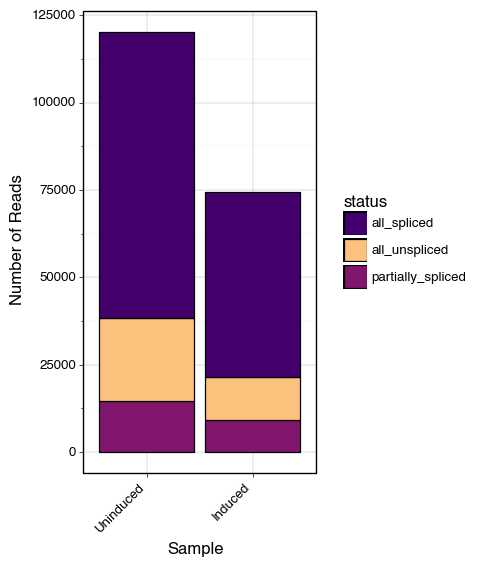

<ggplot: (8771114445013)>

In [220]:
# Plot number of reads by splicing status for treated and untreated conditions
my_colours = ['#43006A', '#FBC17D', '#81176D']

plt_status_number = (ggplot
     (data=df_by_read, mapping=aes(x='treatment', fill = 'status')) + 
      geom_bar(stat = 'count', position = 'stack', colour = 'black') +
      theme_linedraw(base_size = 12, base_family = 'Helvetica') +
      theme(axis_text_x=element_text(rotation=45, hjust=1)) +
      theme(figure_size = (3,6)) +
      xlab('Sample') +
      ylab('Number of Reads') +
      scale_fill_manual(values = my_colours)
    )

plt_status_number

In [221]:
# calculate fraction of all considered introns that are spliced for each treatment condition and in total
spliced = df_by_read['spliced_exact'].sum()
unspliced = df_by_read['unspliced'].sum()

fraction_spliced = spliced/(spliced+unspliced)

print('Number of unspliced introns total is ' + str(float(unspliced)))
print('Number of spliced introns total is ' + str(float(spliced)))
print('Fraction spliced total is ' + str(float(fraction_spliced)))
print('\n')

uninduced = df_by_read.loc[df_by_read['treatment'] == 'Uninduced']
induced = df_by_read.loc[df_by_read['treatment'] == 'Induced']

spliced_uninduced = uninduced['spliced_exact'].sum()
unspliced_uninduced = uninduced['unspliced'].sum()

fraction_spliced_uninduced = spliced_uninduced/(spliced_uninduced+unspliced_uninduced)

print('Number of unspliced introns uninduced is ' + str(float(unspliced_uninduced)))
print('Number of spliced introns uninduced is ' + str(float(spliced_uninduced)))
print('Fraction spliced uninduced is ' + str(float(fraction_spliced_uninduced)))
print('\n')

spliced_induced = induced['spliced_exact'].sum()
unspliced_induced = induced['unspliced'].sum()

fraction_spliced_induced = spliced_induced/(spliced_induced+unspliced_induced)

print('Number of unspliced introns induced is ' + str(float(unspliced_induced)))
print('Number of spliced introns induced is ' + str(float(spliced_induced)))
print('Fraction spliced induced is ' + str(float(fraction_spliced_induced)))

Number of unspliced introns total is 80884.0
Number of spliced introns total is 603308.0
Fraction spliced total is 0.8817817220897058


Number of unspliced introns uninduced is 50736.0
Number of spliced introns uninduced is 362075.0
Fraction spliced uninduced is 0.8770962983060044


Number of unspliced introns induced is 30148.0
Number of spliced introns induced is 241233.0
Fraction spliced induced is 0.8889089508845498


In [222]:
# Create a dataframe with splicing count data coverted to fraction of total reads
all_spliced_uninduced = len((all_spliced_df[all_spliced_df['treatment'] == 'Uninduced']).index)
partially_spliced_uninduced = len((partially_spliced_df[partially_spliced_df['treatment'] == 'Uninduced']).index)
all_unspliced_uninduced = len((all_unspliced_df[all_unspliced_df['treatment'] == 'Uninduced']).index)

all_spliced_induced = len((all_spliced_df[all_spliced_df['treatment'] == 'Induced']).index)
partially_spliced_induced = len((partially_spliced_df[partially_spliced_df['treatment'] == 'Induced']).index)
all_unspliced_induced = len((all_unspliced_df[all_unspliced_df['treatment'] == 'Induced']).index)

total_uninduced = all_spliced_uninduced + partially_spliced_uninduced + all_unspliced_uninduced
total_induced = all_spliced_induced + partially_spliced_induced + all_unspliced_induced

data_list = [['Uninduced', 'all_spliced', all_spliced_uninduced, total_uninduced],
             ['Uninduced', 'partially_spliced', partially_spliced_uninduced, total_uninduced],
             ['Uninduced', 'all_unspliced', all_unspliced_uninduced, total_uninduced],
             ['Induced', 'all_spliced', all_spliced_induced, total_induced],
             ['Induced', 'partially_spliced', partially_spliced_induced, total_induced],
             ['Induced', 'all_unspliced', all_unspliced_induced, total_induced]]

# Create the pandas DataFrame 
df_splicing_status_fraction = pd.DataFrame(data_list, columns = ['treatment', 'splicing_status', 'count', 'total']) 
df_splicing_status_fraction['fraction'] = df_splicing_status_fraction['count']/df_splicing_status_fraction['total']

cat_type = CategoricalDtype(categories=['Uninduced', 'Induced'], ordered=True) # turn group column into a category variable in order to control order of plotting
df_splicing_status_fraction['treatment'] = df_splicing_status_fraction['treatment'].astype(cat_type)
df_splicing_status_fraction

,treatment,splicing_status,count,total,fraction
0,Uninduced,all_spliced,81742,120143,0.680373
1,Uninduced,partially_spliced,14689,120143,0.122263
2,Uninduced,all_unspliced,23712,120143,0.197365
3,Induced,all_spliced,53115,74504,0.712915
4,Induced,partially_spliced,9144,74504,0.122732
5,Induced,all_unspliced,12245,74504,0.164354


### Figure 2C

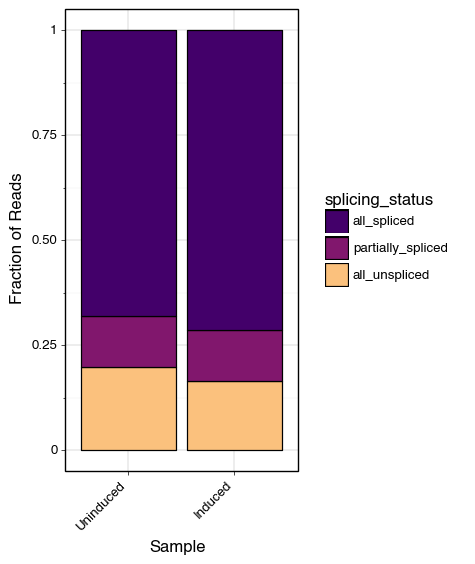

<ggplot: (8771000994481)>

In [223]:
# Plot fraction of reads by splicing status for treated and untreated conditions
# set order that bars will be stacked in bar chart and colours for bars
status_order = ['all_spliced', 'partially_spliced', 'all_unspliced']
df_splicing_status_fraction['splicing_status'] = pd.Categorical(df_splicing_status_fraction['splicing_status'], categories = status_order, ordered=True)
my_colours = ['#43006A', '#81176D', '#FBC17D']

plt_status_fraction = (ggplot
     (data=df_splicing_status_fraction, mapping=aes(x='treatment', y='fraction', fill = 'splicing_status')) + 
      geom_bar(stat = 'identity', position = 'stack', colour = 'black') +
      theme_linedraw(base_size = 12, base_family = 'Helvetica') +
      theme(axis_text_x=element_text(rotation=45, hjust=1)) +
      theme(figure_size = (3,6)) +
      xlab('Sample') +
      ylab('Fraction of Reads') +
      scale_fill_manual(values = my_colours)
    )

plt_status_fraction

In [226]:
# plot the fraction of reads that are all/partial/none spliced for any gene given the input gene ID
# to do this, start with df_by_read with all reads and their splicing status categorized, then use pybedtools to get reads overlapping with the gene region
genes = pd.read_csv('../annotation_files/mm10_active_genes.bed', sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand']) # annotation of all active genes
genes['name'] = genes.name.str.split('.').str[0] # remove version number from gene ID

def plot_splicing_status_distribution_for_gene_of_interest(geneID):
    
    row_of_interest = genes.loc[genes['name'] == geneID]
    row_of_interest.to_csv('gene_of_interest.bed', sep = '\t', index = False, header = False)

    gene_of_interest = pybedtools.BedTool('gene_of_interest.bed') # make bedtool objects for intersection
    all_reads = pybedtools.BedTool('all_reads_with_splicing_status.bed')

    reads_in_gene = all_reads.intersect(gene_of_interest).to_dataframe(names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'readStart', 'readEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts', 'status', 'treatment'])
    
    # same code as above for all genes to count numbers in each category, but here just for the gene of interest (goi)
    all_spliced_uninduced_goi = len((reads_in_gene[(reads_in_gene['treatment'] == 'Uninduced') & (reads_in_gene['status'] == 'all_spliced')]).index)
    partially_spliced_uninduced_goi = len((reads_in_gene[(reads_in_gene['treatment'] == 'Uninduced') & (reads_in_gene['status'] == 'partially_spliced')]).index)
    all_unspliced_uninduced_goi = len((reads_in_gene[(reads_in_gene['treatment'] == 'Uninduced') & (reads_in_gene['status'] == 'all_unspliced')]).index)

    all_spliced_induced_goi = len((reads_in_gene[(reads_in_gene['treatment'] == 'Induced') & (reads_in_gene['status'] == 'all_spliced')]).index)
    partially_spliced_induced_goi = len((reads_in_gene[(reads_in_gene['treatment'] == 'Induced') & (reads_in_gene['status'] == 'partially_spliced')]).index)
    all_unspliced_induced_goi = len((reads_in_gene[(reads_in_gene['treatment'] == 'Induced') & (reads_in_gene['status'] == 'all_unspliced')]).index)

    total_uninduced_goi = all_spliced_uninduced_goi + partially_spliced_uninduced_goi + all_unspliced_uninduced_goi
    total_induced_goi = all_spliced_induced_goi + partially_spliced_induced_goi + all_unspliced_induced_goi

    data_list_goi = [['Uninduced', 'all_spliced', all_spliced_uninduced_goi, total_uninduced_goi],
                 ['Uninduced', 'partially_spliced', partially_spliced_uninduced_goi, total_uninduced_goi],
                 ['Uninduced', 'all_unspliced', all_unspliced_uninduced_goi, total_uninduced_goi],
                 ['Induced', 'all_spliced', all_spliced_induced_goi, total_induced_goi],
                 ['Induced', 'partially_spliced', partially_spliced_induced_goi, total_induced_goi],
                 ['Induced', 'all_unspliced', all_unspliced_induced_goi, total_induced_goi]]

    # Create a pandas DataFrame 
    df_splicing_status_fraction_goi = pd.DataFrame(data_list_goi, columns = ['treatment', 'splicing_status', 'count', 'total']) 
    df_splicing_status_fraction_goi['fraction'] = df_splicing_status_fraction_goi['count']/df_splicing_status_fraction_goi['total']

    cat_type = CategoricalDtype(categories=['Uninduced', 'Induced'], ordered=True) # turn group column into a category variable in order to control order of plotting
    df_splicing_status_fraction_goi['treatment'] = df_splicing_status_fraction_goi['treatment'].astype(cat_type)

    # plot bar graph for the gene of interest
    # set order that bars will be stacked in bar chart and colours for bars
    status_order = ['all_spliced', 'partially_spliced', 'all_unspliced']
    df_splicing_status_fraction_goi['splicing_status'] = pd.Categorical(df_splicing_status_fraction_goi['splicing_status'], categories = status_order, ordered=True)
    my_colours = ['#43006A', '#81176D', '#FBC17D']

    plt_status_fraction_goi = (ggplot
         (data=df_splicing_status_fraction_goi, mapping=aes(x='treatment', y='fraction', fill = 'splicing_status')) + 
          geom_bar(stat = 'identity', position = 'stack', colour = 'black') +
          theme_linedraw(base_size = 12, base_family = 'Helvetica') +
          theme(figure_size = (3,6)) +
          xlab('Sample') +
          ylab('Fraction of Reads') +
          ggtitle(geneID) +
          scale_fill_manual(values = my_colours)
        )
# return either the barplot, the underlying data frame, or a dataframe of all reads counted for that gene
    return plt_status_fraction_goi
#     return df_splicing_status_fraction_goi
#     return plt_status_fraction_goi, df_splicing_status_fraction_goi
#     return reads_in_gene

### Figure 2B and S3A

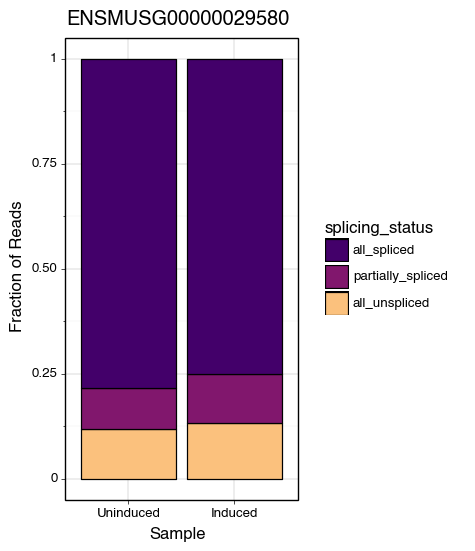

<ggplot: (8770885313841)>

In [227]:
# make individual bar plots for examples shown in Figure 2 and Figure S3
plot_splicing_status_distribution_for_gene_of_interest('ENSMUSG00000029580')

# plot_splicing_status_distribution_for_gene_of_interest('ENSMUSG00000029580').save('Actb_splicing_dist.pdf') # Actb
# plot_splicing_status_distribution_for_gene_of_interest('ENSMUSG00000003814').save('Calr_splicing_dist.pdf') # Calr
# plot_splicing_status_distribution_for_gene_of_interest('ENSMUSG00000035530').save('Eif1_splicing_dist.pdf') # Eif1
# plot_splicing_status_distribution_for_gene_of_interest('ENSMUSG00000084786').save('Ubl5_splicing_dist.pdf') # Ubl5
# plot_splicing_status_distribution_for_gene_of_interest('ENSMUSG00000027829').save('Ccnl1_splicing_dist.pdf') # Ccnl1
# plot_splicing_status_distribution_for_gene_of_interest('ENSMUSG00000025484').save('Bet1l_splicing_dist.pdf') # Bet1l
# plot_splicing_status_distribution_for_gene_of_interest('ENSMUSG00000092558').save('Med20_splicing_dist.pdf') # Med20
# plot_splicing_status_distribution_for_gene_of_interest('ENSMUSG00000052305') # Hbb-bs
# plot_splicing_status_distribution_for_gene_of_interest('ENSMUSG00000073940') # Hbb-bt
# plot_splicing_status_distribution_for_gene_of_interest('ENSMUSG00000069917') # Hba-a2
# plot_splicing_status_distribution_for_gene_of_interest('ENSMUSG00000069919') # Hba-a1

In [228]:
# Calculate read lengths (mapped portion of read) for each category of splicing status
# convert "block length" string (from BED12 format) to a list of integers and sum block lengths to get mapped read length

def get_mapped_read_length(string):
    string_list = string.split(',') # separate string by comma to make a list
    int_list = [int(x) for x in string_list] # convert string list to integer list
    sum_read_length = sum(int_list) # add integers in list
    return sum_read_length

all_unspliced_df['mapped_read_length'] = all_unspliced_df['r_blockSizes'].map(get_mapped_read_length)
partially_spliced_df['mapped_read_length'] = partially_spliced_df['r_blockSizes'].map(get_mapped_read_length)
all_spliced_df['mapped_read_length'] = all_spliced_df['r_blockSizes'].map(get_mapped_read_length)

### Figure S3B

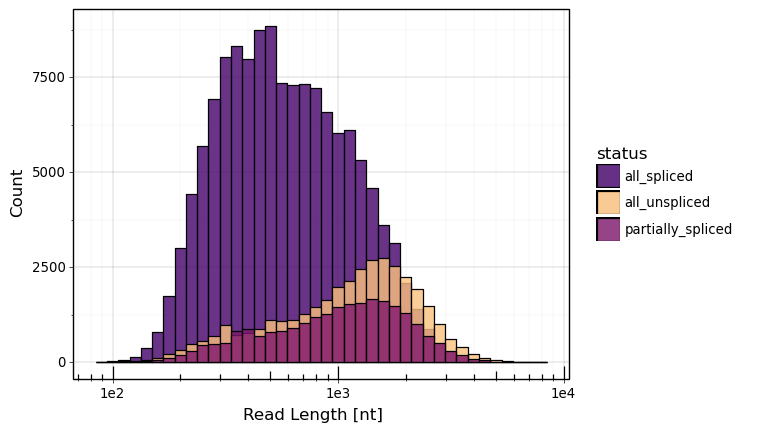

<ggplot: (8770885309785)>

In [229]:
all_unspliced_len = all_unspliced_df[['mapped_read_length', 'status', 'treatment']]
partially_spliced_len = partially_spliced_df[['mapped_read_length', 'status', 'treatment']]
all_spliced_len = all_spliced_df[['mapped_read_length', 'status', 'treatment']]

lengths = pd.concat([all_unspliced_len, partially_spliced_len, all_spliced_len])
cat_type = CategoricalDtype(categories=['all_spliced', 'all_unspliced', 'partially_spliced'], ordered=True) # turn splicing_status column into a category variable in order to control order of plotting

lengths['status'] = lengths['status'].astype(cat_type)

plt_len_by_splicing_status = (ggplot
     (data=lengths, mapping=aes( x='mapped_read_length', fill = 'status')) + 
      geom_histogram(binwidth = .05, position = 'identity', colour = 'black', alpha = 0.8) +
      theme_linedraw(base_size = 12) +
      xlab('Read Length [nt]') +
      ylab('Count') +
      scale_x_log10() + 
      scale_fill_manual(values = ['#43006A', '#FBC17D', '#81176D']) +
      annotation_logticks(sides = "b")
    )

plt_len_by_splicing_status

In [230]:
# print mean read lengths for each category
print(all_spliced_len[all_spliced_len.treatment == 'Uninduced'].mean()['mapped_read_length'])
print(partially_spliced_len[partially_spliced_len.treatment == 'Uninduced'].mean()['mapped_read_length'])
print(all_unspliced_len[all_unspliced_len.treatment == 'Uninduced'].mean()['mapped_read_length'])
print(all_spliced_len[all_spliced_len.treatment == 'Induced'].mean()['mapped_read_length'])
print(partially_spliced_len[partially_spliced_len.treatment == 'Induced'].mean()['mapped_read_length'])
print(all_unspliced_len[all_unspliced_len.treatment == 'Induced'].mean()['mapped_read_length'])

736.5981013432507
1164.6843216011982
1254.710104588394
707.5308105055069
1258.4502405949256
1454.6807676602696


## CoSE Calculation and Figures

In [232]:
# combine introns from induced and uninduced conditions that were filtered above into one dataframe (for all 3 read cutoff values)
splicing_counts_5 = pd.concat([gt_5reads_un, gt_5reads_ind])
splicing_counts_10 = pd.concat([gt_10reads_un, gt_10reads_ind])
splicing_counts_20 = pd.concat([gt_20reads_un, gt_20reads_ind])

# calculate coSE in long format
splicing_counts_5['cose'] = splicing_counts_5['spliced_exact']/(splicing_counts_5['total'])
splicing_counts_10['cose'] = splicing_counts_10['spliced_exact']/(splicing_counts_10['total'])
splicing_counts_20['cose'] = splicing_counts_20['spliced_exact']/(splicing_counts_20['total'])

### Figure S3D

slope: 0.00021971875299949244
intercept: 0.8543735319718561
R squared: 0.0021040682107224683
p-value: 1.2467770991007237e-08
n = 15391 introns


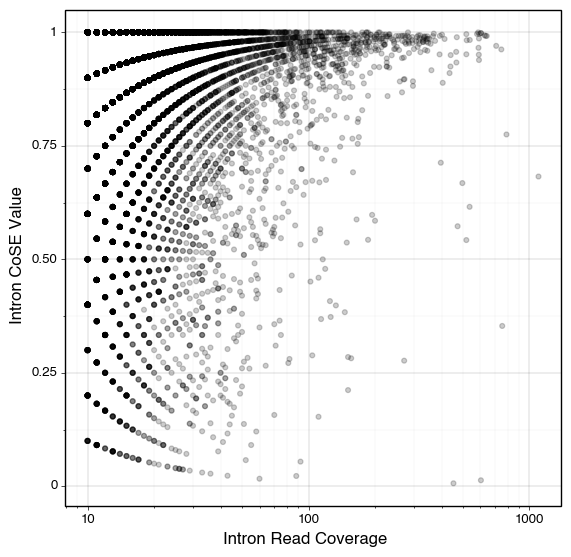

<ggplot: (8770975336401)>

In [236]:
# plot coSE vs read coverage (total count at that intron) for introns with greater than 10 reads
# Calculate linear regression fit
slope, intercept, r_value, p_value, stderr = scipy.stats.linregress(x = splicing_counts_10['total'], y = splicing_counts_10['cose'])
print('slope: ' + str(slope))
print('intercept: ' + str(intercept))
print('R squared: ' + str(r_value**2))
print('p-value: ' + str(p_value))
print('n = ' + str(len(splicing_counts_10)) + ' introns')

# plot scatter plus line with linear fit
cose_coverage = (ggplot
     (data=splicing_counts_10, mapping=aes( x='total', y = 'cose')) + 
      geom_point(alpha = 0.2) +
#       geom_bin2d(binwidth = .01, drop = True) + #to fill in all grey background
#       scale_fill_continuous(name = 'magma') +
#       scale_fill_cmap(name = 'magma') +
#       geom_abline(intercept = intercept, slope = slope) +
      theme_linedraw(base_size = 12, base_family = 'Helvetica') +
      theme(aspect_ratio = 1) +
      scale_x_log10() +
      ylab('Intron CoSE Value') +
      xlab('Intron Read Coverage')
           )
cose_coverage

In [252]:
# Compare Uninduced CoSE values to Uninduced total RNA-seq counts in intron/flanking exons

# # start with list of uninduced introns filtered >10 and add CoSE column
introns_for_rnaseq = gt_10reads_un
introns_for_rnaseq['cose'] = introns_for_rnaseq['spliced_exact']/introns_for_rnaseq['total']

# adjust column names of dataframe with RNAseq intron/exon counts so it can be joined to CoSE dataframe
rnaseq_cts.columns = ['i_name', 'int_over_flanking_exon_cts_norm']

# join CoSE and RNAseq counts
cose_with_RNAseq = pd.merge(introns_for_rnaseq, rnaseq_cts, how = 'left')

# remove rows with NaN -- this is additional filtering that Claudia did for total RNA-seq and PRO-seq
cose_with_RNAseq = cose_with_RNAseq.dropna()

# bin CoSE values
bin_labels = ['0.6', '0.6-0.79', '0.8-0.99', '1']
cut_bins = [0, 0.6, 0.8, 0.999, 1]
cose_with_RNAseq['cose_bin'] = pd.cut(cose_with_RNAseq['cose'], bins=cut_bins, labels=bin_labels)

### Figure S3C

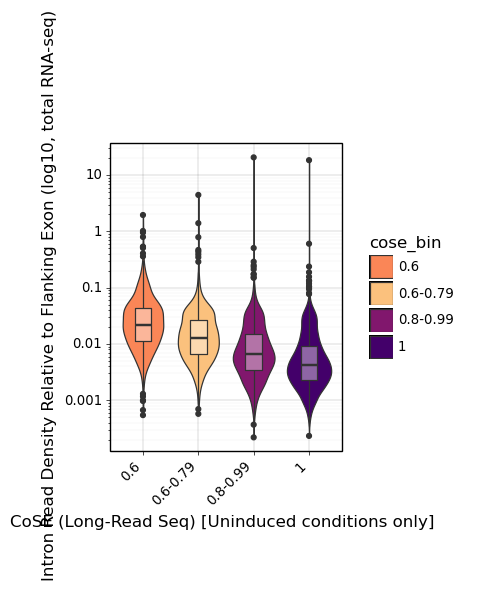

<ggplot: (8770975477217)>

In [254]:
my_colours = ['#FA8657', '#FBC17D', '#81176D', '#43006A']
plt_cose_rnaseq = (ggplot
     (data=cose_with_RNAseq, mapping=aes( x='cose_bin', y = 'int_over_flanking_exon_cts_norm', fill = 'cose_bin')) + 
      geom_violin(width = 0.8) +
      geom_boxplot(width = 0.3, fill = 'white', alpha = 0.4) +
      theme_linedraw(base_size = 12) +
      theme(axis_text_x=element_text(rotation=45, hjust=1)) +
#       theme(figure_size = (2.5,4)) +
      theme(figure_size = (3,4)) +

      xlab('CoSE (Long-Read Seq) [Uninduced conditions only]') +
      ylab('Intron Read Density Relative to Flanking Exon (log10, total RNA-seq)') +
#       scale_y_log10(limits = (0.000001, 5)) +
      scale_y_log10() +
      scale_fill_manual(values = my_colours)
           )
plt_cose_rnaseq

In [266]:
# Calculate variance in CoSE for introns in the same transcript vs. introns in random groups
# first add a column with transcript ID from intron name for introns supported by greater than 10 reads

gt_10reads_un = gt_10reads_un[['i_name', 'condition', 'spliced_exact', 'total']]
gt_10reads_ind = gt_10reads_ind[['i_name', 'condition', 'spliced_exact', 'total']]

gt_10reads_un['cose'] = gt_10reads_un['spliced_exact']/gt_10reads_un['total']
gt_10reads_ind['cose'] = gt_10reads_ind['spliced_exact']/gt_10reads_ind['total']

gt_10reads_un['transcript'] = gt_10reads_un['i_name'].str.split('_').str[0]
gt_10reads_ind['transcript'] = gt_10reads_ind['i_name'].str.split('_').str[0]

In [267]:
# group by transcript name and count the number of unique introns that have CoSE for that transcrpit, and calculate the variance in CoSE
by_transcript_uninduced = gt_10reads_un.groupby('transcript').agg({
    'i_name':'count',
    'cose':'var'})

by_transcript_induced = gt_10reads_ind.groupby('transcript').agg({
    'i_name':'count',
    'cose':'var'})

by_transcript_uninduced = by_transcript_uninduced.reset_index()
by_transcript_induced = by_transcript_induced.reset_index()
by_transcript_uninduced.columns = ['transcript', 'introns_in_txt', 'cose_variance']
by_transcript_induced.columns = ['transcript', 'introns_in_txt', 'cose_variance']

# filter to keep transcripts with CoSE values for at least 3 introns
by_transcript_uninduced_gt3_introns = by_transcript_uninduced.loc[by_transcript_uninduced['introns_in_txt'] >= 3]
by_transcript_induced_gt3_introns = by_transcript_induced.loc[by_transcript_induced['introns_in_txt'] >= 3]

print('Number of unique transcripts with at least 3 CoSE values for introns in uninduced conditions = ' + str(len(by_transcript_uninduced_gt3_introns)))
print('Number of unique transcripts with at least 3 CoSE values for introns in induced conditions = ' + str(len(by_transcript_induced_gt3_introns)))

Number of unique transcripts with at least 3 CoSE values for introns in uninduced conditions = 1240
Number of unique transcripts with at least 3 CoSE values for introns in induced conditions = 788


In [268]:
# create a dictionary of how many transcripts have each number of introns
groupings_dict_uninduced = dict(by_transcript_uninduced_gt3_introns['introns_in_txt'].value_counts())
groupings_dict_induced = dict(by_transcript_induced_gt3_introns['introns_in_txt'].value_counts())
# for example output {3:456, 4:378} means there are 456 transcripts with 3 introns, and 378 transcripts with 4 introns

In [272]:
# Sample x number of random introns for each grouping in the dictionary 

def sample_transcripts(df, n_introns_in_txt, n_transcripts):
    sampled_introns = pd.DataFrame() # create and empty dataframe for sampled introns
    counter = 0 # set counter to keep track of number of times to repeat sampling
    while counter < n_transcripts:
        new_introns = df.sample(n = n_introns_in_txt, replace = False) # select n_intron groupings, set seed
        new_introns['new_ID'] = uuid.uuid4().hex[:6].upper() # add a new unique identifier to each sample of random introns that will be used to group these as a 'transcript' later
        sampled_introns = sampled_introns.append(new_introns) # add the sampled introns to the dataframe
        counter = counter + 1 # add one to the while statement counter
    
    return sampled_introns

# create dataframe of random intron groupings for uninduced condition
grouped_intron_dfs_uninduced = [] # create and empty list to keep all the sampled dfs of introns
for (n_introns_in_txt, n_transcripts) in groupings_dict_uninduced.items(): # loop through the dictionary
    intron_count_grouping_df_uninduced = sample_transcripts(gt_10reads_un, n_introns_in_txt, n_transcripts) # return a dataframe with all 3-intron samplings for e.g.
    grouped_intron_dfs_uninduced.append(intron_count_grouping_df_uninduced) # add sampled introns df to list
    
random_introns_uninduced = pd.concat(grouped_intron_dfs_uninduced) # combine all groups of samplings into one df

# create dataframe of random intron groupings for induced condition
grouped_intron_dfs_induced = [] # create and empty list to keep all the sampled dfs of introns
for (n_introns_in_txt, n_transcripts) in groupings_dict_induced.items(): # loop through the dictionary
    intron_count_grouping_df_induced = sample_transcripts(gt_10reads_ind, n_introns_in_txt, n_transcripts) # return a dataframe with all 3-intron samplings for e.g.
    grouped_intron_dfs_induced.append(intron_count_grouping_df_induced) # add sampled introns df to list
    
random_introns_uninduced = pd.concat(grouped_intron_dfs_uninduced) # combine all groups of samplings into one df
random_introns_induced = pd.concat(grouped_intron_dfs_induced)

# group output by new ID and calculate variance values for each group of random introns
random_by_transcript_uninduced = random_introns_uninduced.groupby('new_ID').agg({ # group here by the unique ID assigned to each group of introns
    'i_name':'count',
    'condition':'first',
    'cose':'var'})

random_by_transcript_induced = random_introns_induced.groupby('new_ID').agg({ # group here by the unique ID assigned to each group of introns
    'i_name':'count',
    'condition':'first',
    'cose':'var'})

random_by_transcript_uninduced = random_by_transcript_uninduced.reset_index()
random_by_transcript_induced = random_by_transcript_induced.reset_index()

random_by_transcript_uninduced.columns = ['transcript', 'introns_in_txt', 'condition', 'cose_variance']
random_by_transcript_induced.columns = ['transcript', 'introns_in_txt', 'condition', 'cose_variance']

# double check that the groupings look the same for the real data and the randomized data
# by_transcript_uninduced_gt3_introns['introns_in_txt'].value_counts() == random_by_transcript_uninduced['introns_in_txt'].value_counts()
# by_transcript_induced_gt3_introns['introns_in_txt'].value_counts() == random_by_transcript_induced['introns_in_txt'].value_counts()

In [273]:
# # melt into long format to plot induced and uninduced cose variance values together
# by_transcript_long = by_transcript.melt(id_vars = ['transcript', 'introns_in_txt'], value_vars = ['cose_var_ind', 'cose_var_unind'])
# random_by_transcript_long = random_by_transcript.melt(id_vars = ['transcript', 'introns_in_txt'], value_vars = ['cose_var_ind', 'cose_var_unind'])

# add condition category to "real data" dataframes
by_transcript_uninduced_gt3_introns['condition'] = 'Uninduced'
by_transcript_induced_gt3_introns['condition'] = 'Induced'

# add category to all dataframes to indicate whether it is same (real) transcripts or random introns
by_transcript_uninduced_gt3_introns['category'] = 'same_transcript'
by_transcript_induced_gt3_introns['category'] = 'same_transcript'
random_by_transcript_uninduced['category'] = 'random_introns'
random_by_transcript_induced['category'] = 'random_introns'

# rearrange dataframes so columns are in the same order
by_transcript_uninduced_gt3_introns = by_transcript_uninduced_gt3_introns[['transcript', 'introns_in_txt', 'condition', 'cose_variance', 'category']]
by_transcript_induced_gt3_introns = by_transcript_induced_gt3_introns[['transcript', 'introns_in_txt', 'condition', 'cose_variance', 'category']]

# by_transcript_long['category'] = 'same_transcript'
# random_by_transcript_long['category'] = 'random_introns'

# stack real and random data together to plot in the same panel
var_data = pd.concat([by_transcript_uninduced_gt3_introns, by_transcript_induced_gt3_introns, random_by_transcript_uninduced, random_by_transcript_induced])
cat_type = CategoricalDtype(categories=['same_transcript', 'random_introns'], ordered=True) # turn category column into a category variable in order to control order of plotting
cond_type = CategoricalDtype(categories=['Uninduced', 'Induced'], ordered=True) # turn category column into a category variable in order to control order of plotting

var_data['category'] = var_data['category'].astype(cat_type)
var_data['condition'] = var_data['condition'].astype(cond_type)

### Figure 2E

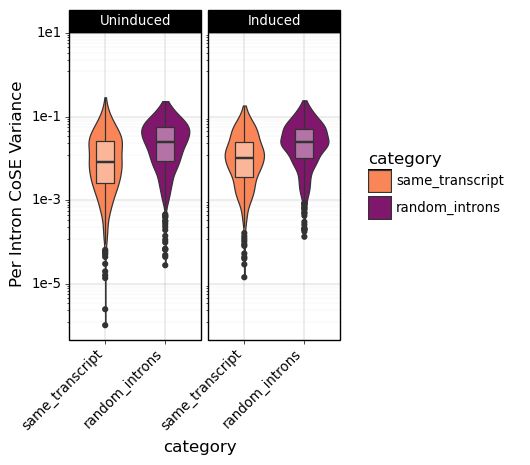

<ggplot: (8770977327433)>

In [274]:
# violin plot same vs random transcript groups for both induced and uninduced
my_colours = ['#FA8657', '#81176D']
plt_var_same_random = (ggplot
     (data=var_data, mapping=aes( x='category', y = 'cose_variance', fill = 'category')) + 
      geom_violin(width = 0.8) +
      geom_boxplot(width = 0.3, fill = 'white', alpha = 0.4) +
      facet_wrap(facets = 'condition', nrow = 1) +
      theme_linedraw(base_size = 12) +
      theme(axis_text_x=element_text(rotation=45, hjust=1)) +
      theme(figure_size = (3.5,4)) +
#       xlab('Intron Comparison') +
      ylab('Per Intron CoSE Variance') +
#       scale_y_log10(limits = (-20,0.1)) +
      scale_y_log10(limits = (0.000001, 5)) +
      scale_fill_manual(values = my_colours)
           )
plt_var_same_random

In [275]:
# calculte p-value by Mann-Whitney U test for same vs random
same_uninduced = var_data.loc[(var_data['category'] == 'same_transcript') & (var_data['condition'] == 'Uninduced')]
same_induced = var_data.loc[(var_data['category'] == 'same_transcript') & (var_data['condition'] == 'Induced')]

random_uninduced = var_data.loc[(var_data['category'] == 'random_introns') & (var_data['condition'] == 'Uninduced')]
random_induced = var_data.loc[(var_data['category'] == 'random_introns') & (var_data['condition'] == 'Induced')]

p_same_random_uninduced = scipy.stats.mannwhitneyu(same_uninduced['cose_variance'], random_uninduced['cose_variance'])[1]
p_same_random_induced = scipy.stats.mannwhitneyu(same_induced['cose_variance'], random_induced['cose_variance'])[1]

print('p-value same vs. random uninduced = ' + str(p_same_random_uninduced))
print('p-value same vs. random induced = ' + str(p_same_random_induced))

p-value same vs. random uninduced = 4.892367757758658e-58
p-value same vs. random induced = 2.6936781838685477e-37


### Figure S3E

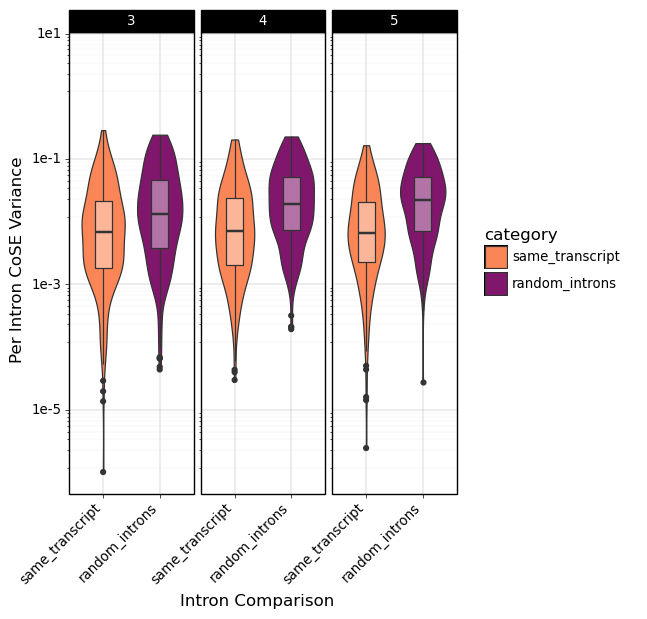

<ggplot: (8770975386149)>

In [276]:
# Plot same vs random separated by number of introns in transcript
transcripts_345_introns = var_data.loc[(var_data['introns_in_txt'] <= 5) & (var_data['introns_in_txt'] >= 3)]

# violin plot same vs random transcript groups for different intron groups
my_colours = ['#FA8657', '#81176D']
plt_var_same_random_intron_groups = (ggplot
     (data=transcripts_345_introns, mapping=aes( x='category', y = 'cose_variance', fill = 'category')) +
      facet_wrap(facets = ['introns_in_txt'], nrow = 1) +
      geom_violin(width = 0.8) +
      geom_boxplot(width = 0.3, fill = 'white', alpha = 0.4) +
      theme_linedraw(base_size = 12) +
      theme(axis_text_x=element_text(rotation=45, hjust=1)) +
      theme(figure_size = (5,6)) +
      xlab('Intron Comparison') +
      ylab('Per Intron CoSE Variance') +
#       scale_y_log10(limits = (-20,0.1)) +
      scale_y_log10(limits = (0.000001, 5)) +
      scale_fill_manual(values = my_colours)
           )
plt_var_same_random_intron_groups

In [277]:
# statistics for intron CoSE variance for transcripts with 3,4, or 5 introns
same3_uninduced = same_uninduced.loc[same_uninduced['introns_in_txt'] == 3]
same4_uninduced = same_uninduced.loc[same_uninduced['introns_in_txt'] == 4]
same5_uninduced = same_uninduced.loc[same_uninduced['introns_in_txt'] == 5]

rand3_uninduced = random_uninduced.loc[random_uninduced['introns_in_txt'] == 3]
rand4_uninduced = random_uninduced.loc[random_uninduced['introns_in_txt'] == 4]
rand5_uninduced = random_uninduced.loc[random_uninduced['introns_in_txt'] == 5]

same3_induced = same_induced.loc[same_induced['introns_in_txt'] == 3]
same4_induced = same_induced.loc[same_induced['introns_in_txt'] == 4]
same5_induced = same_induced.loc[same_induced['introns_in_txt'] == 5]

rand3_induced = random_induced.loc[random_induced['introns_in_txt'] == 3]
rand4_induced = random_induced.loc[random_induced['introns_in_txt'] == 4]
rand5_induced = random_induced.loc[random_induced['introns_in_txt'] == 5]

p_val_same_random_3_uninduced = scipy.stats.mannwhitneyu(same3_uninduced['cose_variance'], rand3_uninduced['cose_variance'])[1]
p_val_same_random_4_uninduced = scipy.stats.mannwhitneyu(same4_uninduced['cose_variance'], rand4_uninduced['cose_variance'])[1]
p_val_same_random_5_uninduced = scipy.stats.mannwhitneyu(same5_uninduced['cose_variance'], rand5_uninduced['cose_variance'])[1]

p_val_same_random_3_induced = scipy.stats.mannwhitneyu(same3_induced['cose_variance'], rand3_induced['cose_variance'])[1]
p_val_same_random_4_induced = scipy.stats.mannwhitneyu(same4_induced['cose_variance'], rand4_induced['cose_variance'])[1]
p_val_same_random_5_induced = scipy.stats.mannwhitneyu(same5_induced['cose_variance'], rand5_induced['cose_variance'])[1]

print('p-value same vs. random 3 introns uninduced = ' + str(p_val_same_random_3_uninduced))
print('p-value same vs. random 4 introns uninduced = ' + str(p_val_same_random_4_uninduced))
print('p-value same vs. random 5 introns uninduced = ' + str(p_val_same_random_5_uninduced) + '\n')

print('p-value same vs. random 3 introns induced = ' + str(p_val_same_random_3_induced))
print('p-value same vs. random 4 introns induced = ' + str(p_val_same_random_4_induced))
print('p-value same vs. random 5 introns induced = ' + str(p_val_same_random_5_induced))


p-value same vs. random 3 introns uninduced = 1.1504795340989997e-07
p-value same vs. random 4 introns uninduced = 3.4616460249617147e-15
p-value same vs. random 5 introns uninduced = 2.152623260377925e-09

p-value same vs. random 3 introns induced = 6.97555759416499e-07
p-value same vs. random 4 introns induced = 1.1855616937548059e-06
p-value same vs. random 5 introns induced = 4.917653059488471e-07


## Save output figures

In [289]:
plt_status_fraction.save('splicing_status_fraction.pdf') # Fig 2C
plt_var_same_random.save('cose_variance_same_vs_random.pdf') # Fig 2E

plt_len_by_splicing_status.save('splicing_status_by_length.pdf') # Fig S3B
plt_cose_rnaseq.save('cose_vs_RNAseq_counts.pdf') # Fig S3C
cose_coverage.save('cose_vs_LRS_coverage.pdf') # Fig S3D
plt_var_same_random_intron_groups.save('cose_same_vs_random_by_intron_number.pdf') # Fig S3E

## Save output files

In [278]:
# save intron lists filtered for different read cutoffs in each condition for Figure 3
gt_20reads_un.to_csv('introns_20read_cutoff_uninduced.txt', sep = '\t', index = False)
gt_10reads_un.to_csv('introns_10read_cutoff_uninduced.txt', sep = '\t', index = False)
gt_5reads_un .to_csv('introns_5read_cutoff_uninduced.txt', sep = '\t', index = False)

gt_20reads_ind.to_csv('introns_20read_cutoff_induced.txt', sep = '\t', index = False)
gt_10reads_ind.to_csv('introns_10read_cutoff_induced.txt', sep = '\t', index = False)
gt_5reads_ind.to_csv('introns_5read_cutoff_induced.txt', sep = '\t', index = False)

In [286]:
# splicing counts summed for all introns in all replicates -- upload to GEO with supplemental files
BEDcols = ['i_chr', 'i_start', 'i_end', 'i_name', 'i_score', 'i_strand', 'spliced_exact', 'merged_unspliced', 'condition']
GEO_upload = pd.concat([induced_reps_combined, uninduced_reps_combined])
GEO_upload[BEDcols].to_csv('GEO_upload_splicing_counts_per_intron.txt', sep = '\t', index = False, header = True)

# splicing counts with replicates kept separate -- for NIC calculation later
combined_intron_and_replicate.to_csv('summed_intron_replicates_counts.txt', sep = '\t', index = False, header = True)

In [ ]:
# # Data grouped by readname (for read splicing status)
# output_filename = "combined_data_{window}_bp_window_splicing_status_counted.bed".format(**locals()) # save filename with window as specified above
# out_cols = ['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'r_start', 'r_end', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'sample', 'spliced_exact', 'unspliced', 'total', 'status']
# out_col_names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'sample', 'spliced_introns', 'unspliced_introns', 'total_introns', 'splicing_status']
# df_by_read.to_csv(output_filename, sep = '\t', index = False,columns = out_cols, header = out_col_names)

In [265]:
# Generate two files (uninduced and induced) with reads coloured by splicing status

# Read in all reads so these can be merged with splicing status classified reads
allBEDfiles = [
    '../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed'
]

all_reads = []
for file in allBEDfiles:
    bed12 = pd.read_csv(file, sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts'])
    treatment = file.split('/')[-1].split('_')[1] # get sample ID from file name
    if treatment == 'untreated':
            bed12['condition'] = 'Uninduced'
    if treatment == 'DMSO':
            bed12['condition'] = 'Induced'
    all_reads.append(bed12)
    
allreads = pd.concat(all_reads)

# read in classified reads
allSpliced = pd.read_csv('all_spliced_reads.bed', sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts', 'splicing_status', 'condition'])
partiallySpliced = pd.read_csv('partially_spliced_reads.bed', sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts', 'splicing_status', 'condition'])
allUnspliced = pd.read_csv('all_unspliced_reads.bed', sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts', 'splicing_status', 'condition'])
status_classified = pd.concat([allSpliced, partiallySpliced, allUnspliced])

# merge the two dataframes so that reads that are unclassified get NaN status
all_reads_status_classified = pd.merge(allreads, 
                                       status_classified[['name', 'splicing_status']],
                                       left_on = ['name'],
                                       right_on = ['name'],
                                       how = 'left')

# assign rbg colour based on splicing status classification
all_reads_status_classified['splicing_status'] = all_reads_status_classified['splicing_status'].astype('str')
all_reads_status_classified.loc[all_reads_status_classified.splicing_status == 'all_spliced', 'rgb'] = '67,0,106'
all_reads_status_classified.loc[all_reads_status_classified.splicing_status == 'partially_spliced', 'rgb'] = '129,23,109'
all_reads_status_classified.loc[all_reads_status_classified.splicing_status == 'all_unspliced', 'rgb'] = '251,193,125'
all_reads_status_classified.loc[all_reads_status_classified.splicing_status == 'nan', 'rgb'] = '97,100,99'

# separate by induced/uninduced
uninduced_coloured = all_reads_status_classified.loc[all_reads_status_classified['condition'] == 'Uninduced']
induced_coloured = all_reads_status_classified.loc[all_reads_status_classified['condition'] == 'Induced']

# write two BED12 files as output to open in IGV and make figures
uninduced_coloured.to_csv('uninduced_coloured.bed', 
               sep = '\t', 
               index = False,
               header = False)
induced_coloured.to_csv('induced_coloured.bed', 
               sep = '\t', 
               index = False,
               header = False)

In [231]:
# # BAM files of reads separated by splicing status (for downstream metagene coverage)

# # Get readnames that are all_spliced, all_unspliced, partially_spliced and save as lists
# all_spliced_readnames = df_by_read.loc[df_by_read['status'] == 'all_spliced', 'r_name'].tolist()
# all_unspliced_readnames = df_by_read.loc[df_by_read['status'] == 'all_unspliced', 'r_name'].tolist()
# partially_spliced_readnames = df_by_read.loc[df_by_read['status'] == 'partially_spliced', 'r_name'].tolist()

# # Combine BAM files from all samples of filtered reads to separate by splicing stauts
# pysam.merge('combined_all_reads.bam', 
#           '../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted.bam', 
#           '../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted.bam',
#           catch_stdout=False)

# pysam.merge('combined_untreated_reads.bam', 
#           '../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted.bam', 
#           '../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted.bam',
#           catch_stdout=False)

# pysam.merge('combined_dmso_reads.bam', 
#           '../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted.bam',
#           catch_stdout=False)

# pysam.sort('-o', 'combined_untreated_reads_sorted.bam', 'combined_untreated_reads.bam', catch_stdout=False)
# pysam.index('combined_untreated_reads_sorted.bam', catch_stdout=False)

# pysam.sort('-o', 'combined_dmso_reads_sorted.bam', 'combined_dmso_reads.bam', catch_stdout=False)
# pysam.index('combined_dmso_reads_sorted.bam', catch_stdout=False)

# pysam.sort('-o', 'combined_all_reads_sorted.bam', 'combined_all_reads.bam', catch_stdout=False)
# pysam.index('combined_all_reads_sorted.bam', catch_stdout=False)

In [152]:
# def separate_read_by_splicing_status(bamfile):
#     bam_in = pysam.AlignmentFile(bamfile, "rb")
    
#     all_spliced = pysam.AlignmentFile('all_spliced_reads_combined.bam', "wb", template = bam_in)
#     all_unspliced = pysam.AlignmentFile('all_unspliced_reads_combined.bam', "wb", template = bam_in)
#     partially_spliced = pysam.AlignmentFile('partially_spliced_reads_combined.bam', "wb", template = bam_in)
    
#     for read in bam_in:
        
#         rname = read.query_name
        
#         if rname in all_spliced_readnames:
#             all_spliced.write(read)
#         if rname in all_unspliced_readnames:
#             all_unspliced.write(read)
#         if rname in partially_spliced_readnames:
#             partially_spliced.write(read)
    
#     bam_in.close()
#     all_spliced.close()
#     all_unspliced.close()
#     partially_spliced.close()

In [153]:
# # Save separated BAM files
# # NOTE: THIS TAKES A VERY LONG TIME BUT IT WORKS
# separate_read_by_splicing_status('combined_all_reads_sorted.bam')